In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from uncertainties import unumpy, ufloat
import scienceplots

plt.style.use(['science', 'notebook'])

### Counting a set number of fringes, then measuring the change in distance of the back mirror (micrometers). We took the average of our counts for each measurement

In [71]:
distance_10 = unumpy.uarray([3.4, 3.5], [0.1, 0.1])
distance_26 = unumpy.uarray([8.9, 8.4], [0.1, 0.1])
distance_50 = unumpy.uarray([17.0], [0.1])
distance_55 = unumpy.uarray([17.5], [0.1])
distance_78 = unumpy.uarray([25.5], [0.1])
distance_75 = unumpy.uarray([24.7], [0.1])
distance_102 = unumpy.uarray([33.1], [0.1])
distance_101 = unumpy.uarray([33.7], [0.1])

# Create array of distances
distances = unumpy.uarray([3.4, 3.5, 8.9, 8.4, 17.0, 17.5, 25.5, 24.7, 33.1, 33.7], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

### Use the equation relating path length and number of fringes to determine the wavelength of the monochromatic laser (see equation below)

\begin{equation}
n \lambda = 2 d
\end{equation}

In [72]:
# Define function to calculate wavelength
def wavelength(num_fringes, distance):
    return (2*num_fringes*10**-6)/(distance)

# Calculate wavelengths
wavelength_10_01 = wavelength(distance_10[0], 10)
wavelength_10_02 = wavelength(distance_10[1], 10)
wavelength_26_01 = wavelength(distance_26[0], 26)
wavelength_26_02 = wavelength(distance_26[1], 26)
wavelength_50 = wavelength(distance_50, 50)
wavelength_55 = wavelength(distance_55, 55)
wavelength_78 = wavelength(distance_78, 78)
wavelength_75= wavelength(distance_75, 75)
wavelength_102 = wavelength(distance_102, 102)
wavelength_101 = wavelength(distance_101, 101)

# Calculate average wavelength
wavelength_avg = (wavelength_10_01 + wavelength_10_02 + wavelength_26_01 + wavelength_26_02 + wavelength_50 + wavelength_55 + wavelength_78 + wavelength_75 + wavelength_102 + wavelength_101)/10
print(r"Average wavelength:", wavelength_avg)

Average wavelength: [6.655992028162091e-07+/-3.1129052798873734e-09]


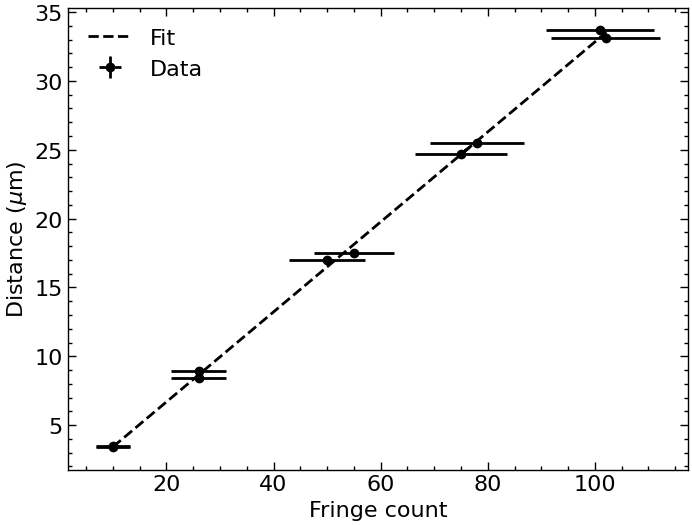

Slope of fit: 0.32670345380209603
Intercept of fit: 0.1567059123482785
Wavelength from slope: 6.53406907604192e-07


In [73]:
# Calculate standard deviation of wavelength
distance_vals = unumpy.nominal_values(distances)
distance_errs = unumpy.std_devs(distances)
fringe_counts = np.array([10, 10, 26, 26, 50, 55, 78, 75, 102, 101])

# Define function to calculate error in wavelength
def fringe_error(num_fringes):
    return np.sqrt(num_fringes)

# Calculate error in wavelength
fringe_err = fringe_error(fringe_counts)

# Fit a line to the data and plot
fit = np.polyfit(fringe_counts, distance_vals, 1)
fit_fn = np.poly1d(fit)
plt.plot(fringe_counts, fit_fn(fringe_counts), '--', c='k')
plt.errorbar(fringe_counts, distance_vals, xerr=fringe_err, yerr=distance_errs, fmt='o', c='k')
plt.xlabel(r"Fringe count")
plt.ylabel(r"Distance ($\mu$m)")
# plt.title(r"Distance vs Fringe count")
plt.legend([r"Fit", r"Data"])
plt.show()

# Print fit parameters
print(r"Slope of fit:", fit[0])
print(r"Intercept of fit:", fit[1])
print(r"Wavelength from slope:", 2*fit[0]*10**-6)

### Measured the zeroth order and the second order from both the right and left sides. This was done to determine if the diffraction grating was perpendicular to the incident beam. We took the differences from both second order measurements and the zeroth order, then averaged them out to determine what the angle for both the second order measurements should be for the grating to be considered perpendicular to the incident beam.

In [74]:
# Measurements for diffraction grating

zeroth_order_will = unumpy.uarray([118 + 53/60], [1/60])
zeroth_order_matthew = unumpy.uarray([118 + 53/60], [1/60])
second_order_right_side_will = unumpy.uarray([172 + 18/60], [1/60])
second_order_right_side_matthew = unumpy.uarray([172 + 20/60], [1/60])
second_order_left_side_will = unumpy.uarray([168 + 30/60], [1/60])
second_order_left_side_matthew = unumpy.uarray([], [1/60])

In [75]:
def diffraction_grating_calc(order, wavelength, angle):
    return (order*wavelength)/(unumpy.sin(angle*np.pi/180))

diffraction_grating_will = diffraction_grating_calc(2, wavelength_avg, second_order_right_side_will - zeroth_order_will)
print(r"Diffraction grating constant (Will):", diffraction_grating_will)
diffraction_grating_matthew = diffraction_grating_calc(2, wavelength_avg, second_order_right_side_matthew - zeroth_order_matthew)
print(r"Diffraction grating constant (Matthew):", diffraction_grating_matthew)

Diffraction grating constant (Will): [1.6578001636193154e-06+/-7.76978230861035e-09]
Diffraction grating constant (Matthew): [1.6570849102160255e-06+/-7.766390028982182e-09]


In [76]:
# Try measuring the diffraction grating now that it is perpendicular to the incident light within 1 minute of error

second_order_left_side_will = unumpy.uarray([52 + 33/60], [1/60])
diffraction_grating_second_order_left_side_will = diffraction_grating_calc(2, wavelength_avg, second_order_left_side_will)

first_order_left_side_matthew = unumpy.uarray([23 + 33/60], [1/60])
diffraction_grating_matthew_first_order_left_side_matthew = diffraction_grating_calc(1, wavelength_avg, first_order_left_side_matthew)

first_order_right_side_matthew = unumpy.uarray([23 + 4/60], [1/60])
diffraction_grating_first_order_right_side_matthew = diffraction_grating_calc(1, wavelength_avg, first_order_right_side_matthew)

second_order_right_side_matthew = unumpy.uarray([51 + 38/60], [1/60])
diffraction_grating_second_order_right_side_matthew = diffraction_grating_calc(2, wavelength_avg, second_order_right_side_matthew)

# Average the diffraction grating constants
diffraction_grating_avg = (diffraction_grating_will + diffraction_grating_matthew + diffraction_grating_second_order_left_side_will + diffraction_grating_matthew_first_order_left_side_matthew + diffraction_grating_first_order_right_side_matthew + diffraction_grating_second_order_right_side_matthew)/6
print(r"Average diffraction grating constant:", diffraction_grating_avg)

# Calculate slits per mm
slits_per_mm = 1/diffraction_grating_avg*10**-3
print(r"Slits per mm:", slits_per_mm)

Average diffraction grating constant: [1.675705244323725e-06+/-7.843015890173617e-09]
Slits per mm: [596.7636631725028+/-2.7931086978420625]


# Helium

\begin{equation}
n \lambda = 2d \sin(\theta),
\end{equation}

where $n$ is the diffraction order, $\lambda$ is the wavelength of light, $d$ is the diffraction grating, and $\theta$ is the measured angle.

In [77]:
# Calculate wavelength from order and angle
def wavelength_calc(order, angle):
    return (diffraction_grating_avg)*unumpy.sin(angle*np.pi/180)/order


# Zeroth order
zeroth_order = unumpy.uarray([134 + 54/60], [1/60])


# First order left side
first_order_left_violet = unumpy.uarray([119 + 19/60], [1/60])
first_order_left_violet_wavelength = wavelength_calc(1, zeroth_order - first_order_left_violet)
print("First order left violet wavelength:", first_order_left_violet_wavelength)

first_order_left_blue = unumpy.uarray([118 + 29/60], [1/60])
first_order_left_blue_wavelength = wavelength_calc(1, zeroth_order - first_order_left_blue)
print("First order left blue wavelength:", first_order_left_blue_wavelength)

first_order_left_cyan = unumpy.uarray([117 + 44/60], [1/60])
first_order_left_cyan_wavelength = wavelength_calc(1, zeroth_order - first_order_left_cyan)
print("First order left cyan wavelength:", first_order_left_cyan_wavelength)

first_order_left_green = unumpy.uarray([117 + 22/60], [1/60])
first_order_left_green_wavelength = wavelength_calc(1, zeroth_order - first_order_left_green)
print("First order left green wavelength:", first_order_left_green_wavelength)

first_order_left_orange = unumpy.uarray([114 + 14/60], [1/60])
first_order_left_orange_wavelength = wavelength_calc(1, zeroth_order - first_order_left_orange)
print("First order left orange wavelength:", first_order_left_orange_wavelength)

first_order_left_red = unumpy.uarray([111 + 16/60], [1/60])
first_order_left_red_wavelength = wavelength_calc(1, zeroth_order - first_order_left_red)
print("First order left red wavelength #1:", first_order_left_red_wavelength)

first_order_left_red_2 = unumpy.uarray([109 + 50/60], [1/60])
first_order_left_red_wavelength_2 = wavelength_calc(1, zeroth_order - first_order_left_red_2)
print("First order left red wavelength #2:", first_order_left_red_wavelength_2)


# Second order left side
second_order_left_violet = unumpy.uarray([102 + 30/60], [1/60])
second_order_left_violet_wavelength = wavelength_calc(2, zeroth_order - second_order_left_violet)
print("\nSecond order left violet wavelength:", second_order_left_violet_wavelength)

second_order_left_blue = unumpy.uarray([100 + 39/60], [1/60])
second_order_left_blue_wavelength = wavelength_calc(2, zeroth_order - second_order_left_blue)
print("Second order left blue wavelength:", second_order_left_blue_wavelength)

second_order_left_cyan = unumpy.uarray([98 + 44/60], [1/60])
second_order_left_cyan_wavelength = wavelength_calc(2, zeroth_order - second_order_left_cyan)
print("Second order left cyan wavelength:", second_order_left_cyan_wavelength)

second_order_left_green = unumpy.uarray([97 + 59/60], [1/60])
second_order_left_green_wavelength = wavelength_calc(2, zeroth_order - second_order_left_green)
print("Second order left green wavelength:", second_order_left_green_wavelength)

second_order_left_orange = unumpy.uarray([90 + 13/60], [1/60])
second_order_left_orange_wavelength = wavelength_calc(2, zeroth_order - second_order_left_orange)
print("Second order left orange wavelength:", second_order_left_orange_wavelength)

second_order_left_red = unumpy.uarray([81 + 59/60], [1/60])
second_order_left_red_wavelength = wavelength_calc(2, zeroth_order - second_order_left_red)
print(r"Second order left red wavelength #1:", second_order_left_red_wavelength)


# First order right side
first_order_right_violet = unumpy.uarray([150 + 41/60], [1/60])
first_order_right_violet_wavelength = wavelength_calc(1, first_order_right_violet - zeroth_order)
print("\nFirst order right violet wavelength:", first_order_right_violet_wavelength)

first_order_right_blue = unumpy.uarray([151 + 30/60], [1/60])
first_order_right_blue_wavelength = wavelength_calc(1, first_order_right_blue - zeroth_order)
print("First order right blue wavelength:", first_order_right_blue_wavelength)

first_order_right_cyan = unumpy.uarray([152 + 15/60], [1/60])
first_order_right_cyan_wavelength = wavelength_calc(1, first_order_right_cyan - zeroth_order)
print("First order right cyan wavelength:", first_order_right_cyan_wavelength)

first_order_right_green = unumpy.uarray([152 + 32/60], [1/60])
first_order_right_green_wavelength = wavelength_calc(1, first_order_right_green - zeroth_order)
print("First order right green wavelength:", first_order_right_green_wavelength)

first_order_right_orange = unumpy.uarray([155 + 47/60], [1/60])
first_order_right_orange_wavelength = wavelength_calc(1, first_order_right_orange - zeroth_order)
print("First order right orange wavelength:", first_order_right_orange_wavelength)

first_order_right_red = unumpy.uarray([158 + 52/60], [1/60])
first_order_right_red_wavelength = wavelength_calc(1, first_order_right_red - zeroth_order)
print("First order right red wavelength:", first_order_right_red_wavelength)

first_order_right_red_2 = unumpy.uarray([160 + 21/60], [1/60])
first_order_right_red_wavelength_2 = wavelength_calc(1, first_order_right_red_2 - zeroth_order)
print(r"First order right red wavelength #2:", first_order_right_red_wavelength_2)


# Second order right side
second_order_right_violet = unumpy.uarray([167 + 54/60], [1/60])
second_order_right_violet_wavelength = wavelength_calc(2, second_order_right_violet - zeroth_order)
print("\nSecond order right violet wavelength:", second_order_right_violet_wavelength)

second_order_right_blue = unumpy.uarray([169 + 55/60], [1/60])
second_order_right_blue_wavelength = wavelength_calc(2, second_order_right_blue - zeroth_order)
print("Second order right blue wavelength:", second_order_right_blue_wavelength)

second_order_right_cyan = unumpy.uarray([171 + 39/60], [1/60])
second_order_right_cyan_wavelength = wavelength_calc(2, second_order_right_cyan - zeroth_order)
print("Second order right cyan wavelength:", second_order_right_cyan_wavelength)

second_order_right_green = unumpy.uarray([172 + 30/60], [1/60])
second_order_right_green_wavelength = wavelength_calc(2, second_order_right_green - zeroth_order)
print("Second order right green wavelength:", second_order_right_green_wavelength)

second_order_right_orange = unumpy.uarray([183 + 7/60], [1/60])
second_order_right_orange_wavelength = wavelength_calc(2, second_order_right_orange - zeroth_order)
print("Second order right orange wavelength:", second_order_right_orange_wavelength)

second_order_right_red = unumpy.uarray([189 + 32/60], [1/60])
second_order_right_red_wavelength = wavelength_calc(2, second_order_right_red - zeroth_order)
print("Second order right red wavelength:", second_order_right_red_wavelength)


# Third order right side
third_order_right_violet = unumpy.uarray([189 + 59/60], [1/60])
third_order_right_violet_wavelength = wavelength_calc(3, third_order_right_violet - zeroth_order)
print("\nThird order right violet wavelength:", third_order_right_violet_wavelength)

First order left violet wavelength: [4.501608478973365e-07+/-2.209100307156967e-09]
First order left blue wavelength: [4.735886506808852e-07+/-2.3131250044404394e-09]
First order left cyan wavelength: [4.945881591382619e-07+/-2.4067593817143254e-09]
First order left green wavelength: [5.048239650067847e-07+/-2.4525206036780043e-09]
First order left orange wavelength: [5.91407598173164e-07+/-2.8421920588226074e-09]
First order left red wavelength #1: [6.717602088398205e-07+/-3.2069225800750404e-09]
First order left red wavelength #2: [7.099502509304645e-07+/-3.3810309061492807e-09]

Second order left violet wavelength: [4.4894388519773916e-07+/-2.121305965068243e-09]
Second order left blue wavelength: [4.715475844349306e-07+/-2.22535695299082e-09]
Second order left cyan wavelength: [4.944470764862718e-07+/-2.3308918345453133e-09]
Second order left green wavelength: [5.032585392051741e-07+/-2.371529779884263e-09]
Second order left orange wavelength: [5.891678341558749e-07+/-2.76842503931

### Make plot for helium spectrum

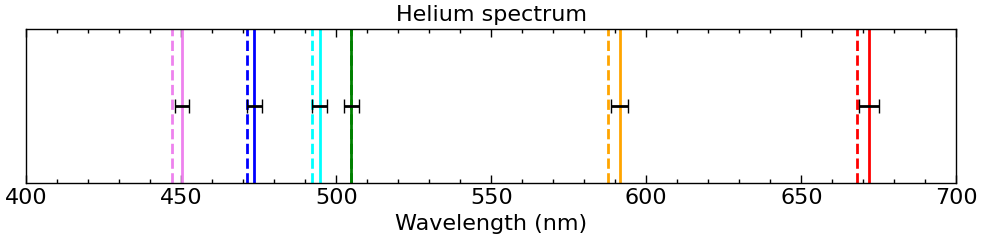

In [78]:
# First order helium spectrum
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
ax.set_title(r"Helium spectrum")
ax.set_xlabel(r"Wavelength (nm)")
ax.set_xlim(400, 700)
ax.set_yticks([])

# First order helium from our measurements
ax.axvline((unumpy.nominal_values(first_order_left_violet_wavelength))*10**9, c='violet', label='Violet')
ax.axvline((unumpy.nominal_values(first_order_left_blue_wavelength))*10**9, c='blue', label='Blue')
ax.axvline((unumpy.nominal_values(first_order_left_cyan_wavelength))*10**9, c='cyan', label='Cyan')
ax.axvline((unumpy.nominal_values(first_order_left_green_wavelength))*10**9, c='green', label='Green')
ax.axvline((unumpy.nominal_values(first_order_left_orange_wavelength))*10**9, c='orange', label='Orange')
ax.axvline((unumpy.nominal_values(first_order_left_red_wavelength))*10**9, c='red', label='Red')

# First order helium from literature (http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html#c1)
ax.axvline(447.148, c='violet', ls='--', label='Violet (Lit.)')
ax.axvline(471.314, c='blue', ls='--', label='Blue (Lit.)')
ax.axvline(492.193, c='cyan', ls='--', label='Cyan (Lit.)')
ax.axvline(504.774, c='green', ls='--', label='Green (Lit.)')
ax.axvline(587.562, c='orange', ls='--', label='Orange (Lit.)')
ax.axvline(667.815, c='red', ls='--', label='Red (Lit.)')

# First order helium from our measurements error bars
ax.errorbar((unumpy.nominal_values(first_order_left_violet_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_violet_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_blue_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_blue_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_cyan_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_cyan_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_green_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_green_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_orange_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_orange_wavelength))*10**9, fmt='None', c='k', capsize=5)
ax.errorbar((unumpy.nominal_values(first_order_left_red_wavelength))*10**9, 0, xerr=(unumpy.std_devs(first_order_left_red_wavelength))*10**9, fmt='None', c='k', capsize=5)

plt.savefig("../figures/helium_spectrum_first_order.pdf", bbox_inches='tight')
plt.show()

# Hydrogen

\begin{equation}
n \lambda = 2d \sin(\theta),
\end{equation}

where $n$ is the diffraction order, $\lambda$ is the wavelength of light, $d$ is the diffraction grating, and $\theta$ is the measured angle.

In [79]:
# First order left side

zeroth_order = unumpy.uarray([134 + 53/60], [1/60])


# First order left side
first_order_left_violet = unumpy.uarray([119 + 9/60], [1/60])
first_order_left_violet_wavelength = wavelength_calc(1, zeroth_order - first_order_left_violet)
print("First order left violet wavelength:", first_order_left_violet_wavelength)

first_order_left_cyan = unumpy.uarray([117 + 56/60], [1/60])
first_order_left_cyan_wavelength = wavelength_calc(1, zeroth_order - first_order_left_cyan)
print("First order left cyan wavelength:", first_order_left_cyan_wavelength)

first_order_left_red = unumpy.uarray([111 + 8/60], [1/60])
first_order_left_red_wavelength = wavelength_calc(1, zeroth_order - first_order_left_red)
print("First order left red wavelength:", first_order_left_red_wavelength)


# Second order left side
second_order_left_violet = unumpy.uarray([104 + 30/60], [1/60])
second_order_left_violet_wavelength = wavelength_calc(2, zeroth_order - second_order_left_violet)
print("\nSecond order left violet wavelength:", second_order_left_violet_wavelength)

second_order_left_cyan = unumpy.uarray([99 + 12/60], [1/60])
second_order_left_cyan_wavelength = wavelength_calc(2, zeroth_order - second_order_left_cyan)
print("Second order left cyan wavelength:", second_order_left_cyan_wavelength)

second_order_left_red = unumpy.uarray([83 + 8/60], [1/60])
second_order_left_red_wavelength = wavelength_calc(2, zeroth_order - second_order_left_red)
print("Second order left red wavelength:", second_order_left_red_wavelength)


# First order right side
first_order_right_violet = unumpy.uarray([150 + 10/60], [1/60])
first_order_right_violet_wavelength = wavelength_calc(1, first_order_right_violet - zeroth_order)
print("\nFirst order right violet wavelength:", first_order_right_violet_wavelength)

first_order_right_cyan = unumpy.uarray([152 + 0/60], [1/60])
first_order_right_cyan_wavelength = wavelength_calc(1, first_order_right_cyan - zeroth_order)
print("First order right cyan wavelength:", first_order_right_cyan_wavelength)

first_order_right_red = unumpy.uarray([158 + 20/60], [1/60])
first_order_right_red_wavelength = wavelength_calc(1, first_order_right_red - zeroth_order)
print("First order right red wavelength:", first_order_right_red_wavelength)


# Second order right side
second_order_right_violet = unumpy.uarray([166 + 49/60], [1/60])
second_order_right_violet_wavelength = wavelength_calc(2, second_order_right_violet - zeroth_order)
print("\nSecond order right violet wavelength:", second_order_right_violet_wavelength)

second_order_right_cyan = unumpy.uarray([171 + 8/60], [1/60])
second_order_right_cyan_wavelength = wavelength_calc(2, second_order_right_cyan - zeroth_order)
print("Second order right cyan wavelength:", second_order_right_cyan_wavelength)

second_order_right_red = unumpy.uarray([188 + 1/60], [1/60])
second_order_right_red_wavelength = wavelength_calc(2, second_order_right_red - zeroth_order)
print("Second order right red wavelength:", second_order_right_red_wavelength)

First order left violet wavelength: [4.543850241546811e-07+/-2.227819792363348e-09]
First order left cyan wavelength: [4.885301806408718e-07+/-2.379712268661593e-09]
First order left red wavelength: [6.748847403303064e-07+/-3.2211511105295523e-09]

Second order left violet wavelength: [4.237714851557989e-07+/-2.0055945698958466e-09]
Second order left cyan wavelength: [4.887235912183591e-07+/-2.304503890863446e-09]
Second order left red wavelength: [6.579798497665381e-07+/-3.0870104230626787e-09]

First order right violet wavelength: [4.4170326829968194e-07+/-2.1716722781187374e-09]
First order right cyan wavelength: [4.931907886975109e-07+/-2.4005180823951954e-09]
First order right red wavelength: [6.668446084536117e-07+/-3.1845440627830042e-09]

Second order right violet wavelength: [4.431671946653142e-07+/-2.0947356916048377e-09]
Second order right cyan wavelength: [4.954303393910364e-07+/-2.3354258151059123e-09]
Second order right red wavelength: [6.703104451850298e-07+/-3.144146607

## Make plot for hydrogen spectrum

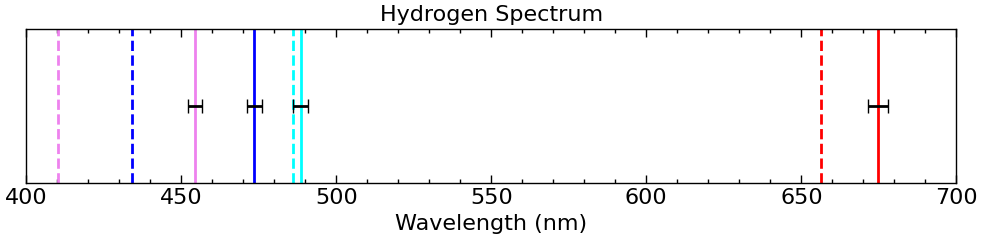

In [80]:
# First order hydrogen spectrum
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
ax.set_title("Hydrogen Spectrum")
ax.set_xlabel("Wavelength (nm)")
ax.set_xlim(400, 700)
ax.set_yticks([])

# First order hydrogen from our measurements
ax.axvline((unumpy.nominal_values(first_order_left_violet_wavelength))*10**9, c='violet', label='Violet')
ax.axvline((unumpy.nominal_values(first_order_left_blue_wavelength))*10**9, c='blue', label='Blue')
ax.axvline((unumpy.nominal_values(first_order_left_cyan_wavelength))*10**9, c='cyan', label='Cyan')
ax.axvline((unumpy.nominal_values(first_order_left_red_wavelength))*10**9, c='red', label='Red')

# First order hydrogen from literature (http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/atspect.html)
ax.axvline(410.174, c='violet', label='Violet', linestyle='--')
ax.axvline(434.047, c='blue', label='Blue', linestyle='--')
ax.axvline(486.133, c='cyan', label='Cyan', linestyle='--')
ax.axvline(656.272, c='red', label='Red', linestyle='--')

# First order hydrogen from our measurements error bars
ax.errorbar(unumpy.nominal_values(first_order_left_violet_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_violet_wavelength)*10**9, fmt='None', c='k', capsize=5)
ax.errorbar(unumpy.nominal_values(first_order_left_blue_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_blue_wavelength)*10**9, fmt='None', c='k', capsize=5)
ax.errorbar(unumpy.nominal_values(first_order_left_cyan_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_cyan_wavelength)*10**9, fmt='None', c='k', capsize=5)
ax.errorbar(unumpy.nominal_values(first_order_left_red_wavelength)*10**9, 0, xerr=unumpy.std_devs(first_order_left_red_wavelength)*10**9, fmt='None', c='k', capsize=5)

plt.savefig("../figures/hydrogen_spectrum_first_order.pdf", bbox_inches='tight')
plt.show()

## Determining angle of minimal deviation:

Kept scope in same spot

Moved the base cw and measured angle where lines stopped moving

Moved the base ccw and measured angle where lines stopped moving

In [81]:
stopped_angle_cw  = unumpy.uarray([254 + 17/60], [1/60])
stopped_angle_ccw = unumpy.uarray([255 + 47/60], [1/60])

mean_stopped_angle = (stopped_angle_cw + stopped_angle_ccw)/2
std_dev_stopped_angle = ((stopped_angle_cw[0] - mean_stopped_angle[0])**2 + (stopped_angle_ccw[0] - mean_stopped_angle[0])**2/2)**0.5
print("Mean stopped angle:", mean_stopped_angle)
print("Standard deviation of stopped angle:", std_dev_stopped_angle)

Mean stopped angle: [255.03333333333333+/-0.011785113019775792]
Standard deviation of stopped angle: 0.919+/-0.014


# Helium with prism

In [82]:
zeroth_order = unumpy.uarray([314 + 18/60], [1/60])

helium_violet_angle = unumpy.uarray([252 + 7/60], [0.1])
helium_blue_angle = unumpy.uarray([252 + 57/60], [0.1])
helium_cyan_angle = unumpy.uarray([253 + 36/60], [0.1])
helium_green_angle = unumpy.uarray([253 + 50/60], [0.1])
helium_orange_angle = unumpy.uarray([255 + 26/60], [0.1])
helium_red_angle = unumpy.uarray([256 + 21/60], [0.1])
helium_red_angle_2 = unumpy.uarray([256 + 40/60], [0.1])

# Hydrogen with prism

In [83]:
hydrogen_violet_angle = unumpy.uarray([251 + 34/60], [0.1])
hydrogen_cyan_angle = unumpy.uarray([253 + 27/60], [0.1])
hydrogen_red_angle = unumpy.uarray([256 + 14/60], [0.1])

# Apex Angle
The apex angle is half the difference between the reflection angles on either side of the prism, with the apex corner facing directly towards the light source

In [84]:
zero_angle = unumpy.uarray([314 + 41/60], [0.1])

right_reflection_angle = unumpy.uarray([19 + 6/60], [0.1])
left_reflection_angle = unumpy.uarray([259 + 7/60], [0.1])

apex_angle = 0.5*np.abs((360 - zero_angle + right_reflection_angle) - (zero_angle - left_reflection_angle))


band_width_left = unumpy.uarray([314 + 18/60], [0.1])
band_width_right = unumpy.uarray([314 + 23/60], [0.1])


def index_of_refraction(min_dev_angle, apex_angle):
    return unumpy.sin((min_dev_angle*np.pi/180 + apex_angle*np.pi/180)/2)/unumpy.sin((apex_angle*np.pi/180)/2)

helium_violet_index = index_of_refraction(helium_violet_angle, apex_angle)
print("Helium violet index of refraction:", helium_violet_index)
helium_blue_index = index_of_refraction(helium_blue_angle, apex_angle)
print("Helium blue index of refraction:", helium_blue_index)
print("apex_angle:", apex_angle)

Helium violet index of refraction: [20.336102219705992+/-0.5798961854672285]
Helium blue index of refraction: [20.218892553736506+/-0.5768153354303216]
apex_angle: [4.424999999999997+/-0.12247448713915891]
